# Summary of end results:


* **FFNN** (*Wikipedia* articles data): **0.42**
* **FFNN** (*Arxiv* papers data): **0.25**
* **SVM** (*Wikipedia* articles data): **0.47**
* **SVM** (*Arxiv* papers data): **0.285**
* **MNB** (*Wikipedia* articles data): **0.535**
* **MNB** (*Arxiv* papers data): **0.263**

# 3rd Party Libraries

In [0]:
!pip install wikipedia
!pip install wikipedia-api

In [2]:
#Keras Neural Network (Feedforward)
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense
#Computations 
import numpy as np
#Progress bar
from tqdm import tqdm_notebook as tqdm 

#Sklearn classifiers and utils
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

Using TensorFlow backend.


# Project Library (modules)

In [3]:
import doc_utils #cleaning and other helper functions
from max_sim_classifier import MaxSimClassifier #maximum similarity classifier custom library

#Parser libraries: wikipedia dataset and arxiv dataset
from arxiv_parser import arxiv_parser
from wiki_parser import concurrentGetWikiFullPage, concurrentGetAllCatArticles

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data retrieval: Wiki and ArXiv datasets

## Wikipedia Dataset (Definitions + Articles)

In [4]:
engineering_topic_defs = concurrentGetWikiFullPage(topics_list = doc_utils.ALL_TOPICS )

engineering_articles, n_test_samples = concurrentGetAllCatArticles(doc_utils.ALL_TOPICS, full_text_test=True)

Obtaining full wikipedia page for the topic: Chemical engineering. (Definition of Class #[0])
Obtaining full wikipedia page for the topic: Biomedical engineering. (Definition of Class #[1])
Obtaining full wikipedia page for the topic: Civil engineering. (Definition of Class #[2])
Obtaining full wikipedia page for the topic: Electrical engineering. (Definition of Class #[3])
Obtaining full wikipedia page for the topic: Mechanical engineering. (Definition of Class #[4])
Obtaining full wikipedia page for the topic: Aerospace engineering. (Definition of Class #[5])
Obtaining full wikipedia page for the topic: Software engineering. (Definition of Class #[6])
Obtaining full wikipedia page for the topic: Industrial engineering. (Definition of Class #[7])
Obtaining full wikipedia page for the topic: Computer engineering. (Definition of Class #[8])
Retrieved 41 articles from category topic 'Computer engineering'[TopicID:8]
Retrieved 57 articles from category topic 'Software engineering'[TopicID

Mean number of words per topic definition: 3190.5555555555557


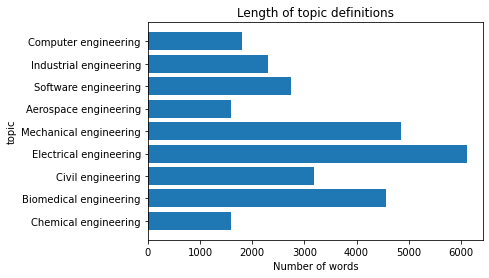

In [5]:
doc_utils.plotDefinitionLengths(engineering_topic_defs ,dataset_type="wiki")

## arXiv Dataset (Papers)

In [6]:
arxiv_topic_defs = concurrentGetWikiFullPage(topics_list = doc_utils.ARXIV_WIKI_TOPICS)

arxiv_papers = arxiv_parser(100)

Obtaining full wikipedia page for the topic: Computer science. (Definition of Class #[0])
Obtaining full wikipedia page for the topic: Economics. (Definition of Class #[1])
Obtaining full wikipedia page for the topic: Systems engineering. (Definition of Class #[2])
Obtaining full wikipedia page for the topic: Mathematics. (Definition of Class #[3])
Obtaining full wikipedia page for the topic: Astrophysics. (Definition of Class #[4])
Obtaining full wikipedia page for the topic: Computational biology. (Definition of Class #[5])
Obtaining full wikipedia page for the topic: Quantitative finance. (Definition of Class #[6])
Obtaining full wikipedia page for the topic: Statistics. (Definition of Class #[7])
Retrieved 800 papers in total from 8 subjects (100 from each).


Mean number of words per topic definition: 3689.75


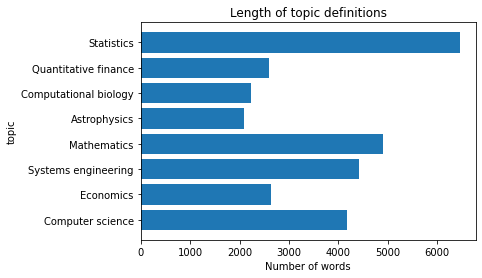

In [7]:
doc_utils.plotDefinitionLengths(arxiv_topic_defs ,dataset_type="arxiv")

# Feed Forward Neural Network

## Wikipedia dataset

### Data preprocessing

In [0]:
x_train, y_train, x_test, y_test, dictionary = doc_utils.processNeuralNetData(engineering_topic_defs,
                                                                              engineering_articles,
                                                                              dataset_type = "wiki",
                                                                              preprocess = 'simple')

### Model train and evaluation

In [9]:
mean_acc = 0
max_acc = 0
acc_list = []
n_runs = 30
print("Executing",n_runs,"runs of model training/evaluation...\n")

for i in tqdm(range(n_runs)):
    clear_session()

    #Neural Architecture Definition
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(len(dictionary),)))

    model.add(Dense(len(doc_utils.ALL_TOPICS), activation='softmax'))
    #Model compilation
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
    #Model training
    hist = model.fit(x_train, y_train, epochs=5,verbose=0)

    model_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    acc_list.append(model_acc)

    if model_acc >= max(acc_list):
        #save best model to date
        model_json = model.to_json()
        with open("wiki_model.json", "w") as f:
            f.write(model_json)
        model.save_weights("wiki_model.h5")


print("\nResulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 30 runs of model training/evaluation...



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys




Resulting Average accuracy: 0.32045606871445975
Best accuracy: 0.4195170998573303


In [11]:
from keras.models import model_from_json
#loading best model obtained
json_f = open('wiki_model.json', 'r')
best_model_json = json_f.read()
json_f.close()
best_model = model_from_json(best_model_json)
#loading weights
best_model.load_weights("wiki_model.h5")

# evaluate loaded model on test data
best_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
predictions = best_model.predict_classes(x_test) #for later building confusion matrix
print("Model accuracy:",best_model.evaluate(x_test, y_test, verbose=0)[1])

Model accuracy: 0.4195170998573303


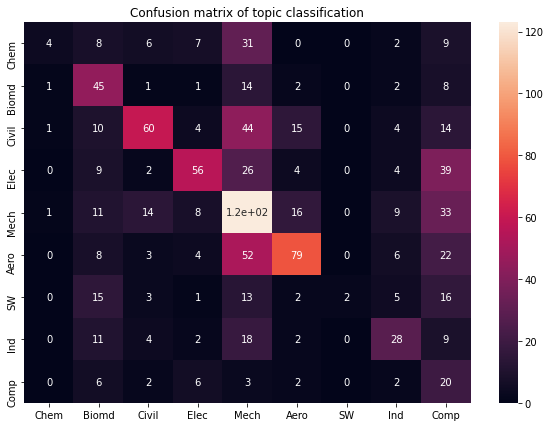

In [12]:
doc_utils.plotConfMatrix(y_test, predictions, model = "NN")

## ArXiv dataset

### Data preprocessing

In [0]:
x_train, y_train, x_test, y_test, dictionary  = doc_utils.processNeuralNetData(arxiv_topic_defs,
                                                                                arxiv_papers,
                                                                                dataset_type = "arxiv",
                                                                                preprocess = 'simple')

### Model train and evaluation

In [16]:
mean_acc = 0
max_acc = 0
acc_list = []
n_runs = 30 

print("Executing",n_runs,"runs of model training/evaluation...\n")

for i in tqdm(range(n_runs)):
    clear_session()

    #Neural Architecture Definition
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(len(dictionary),)))

    model.add(Dense(len(doc_utils.ARXIV_WIKI_TOPICS), activation='softmax'))
    #Model compilation
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
    #Model training
    hist = model.fit(x_train, y_train, epochs=15,verbose=0)

    model_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    acc_list.append(model_acc)

    if model_acc >= max(acc_list):
        #save best model to date
        model_json = model.to_json()
        with open("arxiv_model.json", "w") as f:
            f.write(model_json)
        model.save_weights("arxiv_model.h5")


print("\nResulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 30 runs of model training/evaluation...



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Resulting Average accuracy: 0.19166666666666668
Best accuracy: 0.2475000023841858


In [17]:
#loading best model obtained
json_f = open('arxiv_model.json', 'r')
best_model_json = json_f.read()
json_f.close()
best_model = model_from_json(best_model_json)
#loading weights
best_model.load_weights("arxiv_model.h5")

# evaluate loaded model on test data
best_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
predictions = best_model.predict_classes(x_test) #for later building confusion matrix
print("Model accuracy:",best_model.evaluate(x_test, y_test, verbose=0)[1])

Model accuracy: 0.2475000023841858


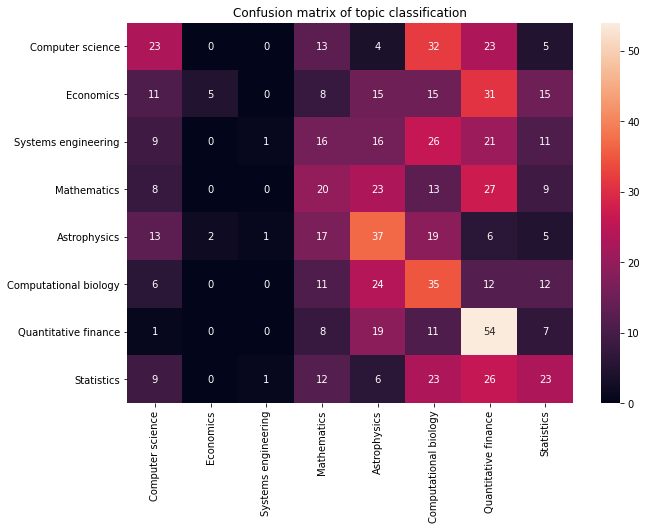

In [19]:
doc_utils.plotConfMatrix(y_test, predictions, model = "NN",dataset_type="arxiv")

## FF.NN. Results:

* **Wikipedia articles dataset**: Top1 Accuracy **0.42**
* **Arxiv papers dataset**: Top1 Accuracy **0.25**


# Support Vector Machine (SVM)

## Wikipedia dataset

### Data preprocessing

In [0]:
x_train, y_train, x_test, y_test = doc_utils.processClassifierData(engineering_topic_defs, 
                                                                   engineering_articles,
                                                                   topics = doc_utils.ALL_TOPICS,
                                                                   dataset_type ="wiki")

### Model train and evaluation

In [18]:
n_runs = 100
mean_acc = 0
max_acc = 0

acc_list = []
best_svm = None

print("Executing",n_runs,"runs of SVM classifiers...")

for i in tqdm(range(n_runs)):

    text_clf_svm = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf-svm', SGDClassifier()),
                            ])    

    _ = text_clf_svm.fit(x_train, y_train)

    predicted_svm = text_clf_svm.predict(x_test)
    classification_accuracy = np.mean(predicted_svm == y_test)

    acc_list.append(classification_accuracy)
    
    if classification_accuracy >= max(acc_list):
        best_svm = text_clf_svm

print("Resulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 100 runs of SVM classifiers...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Resulting Average accuracy: 0.2570523138832998
Best accuracy: 0.4678068410462777


## arXiv dataset

### Data preprocessing

In [0]:
x_train, y_train, x_test, y_test = doc_utils.processClassifierData(arxiv_topic_defs, 
                                                                   arxiv_papers,
                                                                   topics = doc_utils.ARXIV_WIKI_TOPICS,
                                                                   dataset_type ="arxiv")

### Model train and evaluation

In [20]:
n_runs = 100
mean_acc = 0
max_acc = 0

acc_list = []
best_svm = None

print("Executing",n_runs,"runs of SVM classifiers...")

for i in tqdm(range(n_runs)):

    text_clf_svm = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf-svm', SGDClassifier()),
                            ])    

    _ = text_clf_svm.fit(x_train, y_train)

    predicted_svm = text_clf_svm.predict(x_test)
    classification_accuracy = np.mean(predicted_svm == y_test)

    acc_list.append(classification_accuracy)
    
    if classification_accuracy >= max(acc_list):
        best_svm = text_clf_svm

print("Resulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 100 runs of SVM classifiers...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Resulting Average accuracy: 0.1992375
Best accuracy: 0.285


# Multinomial Naive Bayes (MNB)

## Wikipedia dataset

### Data preprocessing

In [0]:
x_train, y_train, x_test, y_test = doc_utils.processClassifierData(engineering_topic_defs, 
                                                                   engineering_articles,
                                                                   topics = doc_utils.ALL_TOPICS,
                                                                   dataset_type ="wiki")

### Model train and evaluation

In [22]:
n_runs = 100
mean_acc = 0
max_acc = 0

acc_list = []
best_NB = None

print("Executing",n_runs,"runs of Multinomial NaiveBayes classifiers...")

for i in tqdm(range(n_runs)):

    text_clf_NB = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf-NB', MultinomialNB()),
                            ])    

    _ = text_clf_NB.fit(x_train, y_train)

    predicted_NB = text_clf_NB.predict(x_test)
    classification_accuracy = np.mean(predicted_NB == y_test)

    acc_list.append(classification_accuracy)
    
    if classification_accuracy >= max(acc_list):
        best_NB = text_clf_NB

print("Resulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 100 runs of Multinomial NaiveBayes classifiers...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Resulting Average accuracy: 0.5352112676056339
Best accuracy: 0.5352112676056338


## arXiv dataset

### Data preprocessing

In [0]:
x_train, y_train, x_test, y_test = doc_utils.processClassifierData(arxiv_topic_defs, 
                                                                   arxiv_papers,
                                                                   topics = doc_utils.ARXIV_WIKI_TOPICS,
                                                                   dataset_type ="arxiv")

### Model train and evaluation

In [24]:
n_runs = 100
mean_acc = 0
max_acc = 0

acc_list = []
best_NB = None

print("Executing",n_runs,"runs of Multinomial NaiveBayes classifiers...")

for i in tqdm(range(n_runs)):

    text_clf_NB = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf-NB', MultinomialNB()),
                            ])    

    _ = text_clf_NB.fit(x_train, y_train)

    predicted_NB = text_clf_NB.predict(x_test)
    classification_accuracy = np.mean(predicted_NB == y_test)

    acc_list.append(classification_accuracy)
    
    if classification_accuracy >= max(acc_list):
        best_NB = text_clf_NB

print("Resulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 100 runs of Multinomial NaiveBayes classifiers...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Resulting Average accuracy: 0.2625
Best accuracy: 0.2625


# Baseline results summary (Top1 Accuracies)


* **FFNN** (*Wikipedia* articles data): **0.42**
* **FFNN** (*Arxiv* papers data): **0.25**
* **SVM** (*Wikipedia* articles data): **0.47**
* **SVM** (*Arxiv* papers data): **0.285**
* **MNB** (*Wikipedia* articles data): **0.535**
* **MNB** (*Arxiv* papers data): **0.263**